In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from config import *
import random
from itertools import combinations,permutations
import time

/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [2]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[batch_size, N])
y = tf.placeholder(tf.float32, shape=[batch_size, K])
R_init = tf.placeholder(tf.float32, shape=[batch_size, N])

net_dict = {}
bp_iter_num = 5
RNN = 1
ss = np.hstack([0,np.arange(n)[::-1]+1])
int_L = 5
deci_L = 2
step = 2**-deci_L
_min = -2**(int_L+deci_L)*step
_max = (2**(int_L+deci_L)-1)*step
fix = 0
if(fix):
    inf_num = 2**(int_L-1)
else:
    inf_num = 1000

# initial
for i in range(n+1):
    for j in range(N):
        net_dict["L_{0}{1}{2}".format(i,j,0)] = tf.zeros((batch_size))
        net_dict["R_{0}{1}{2}".format(i,j,0)] = tf.zeros((batch_size))

if(RNN):
    LV = tf.Variable(np.float32(np.ones((n,N,1))))
    RV = tf.Variable(np.float32(np.ones((n,N,1))))
else:
    LV = tf.Variable(np.float32(np.ones((n,N,bp_iter_num))))
    RV = tf.Variable(np.float32(np.ones((n,N,bp_iter_num))))

for j in range(N):
    net_dict["L_{0}{1}{2}".format(n,j,0)] = tf.ones((1))*x[:,j]    
    net_dict["R_{0}{1}{2}".format(0,j,0)] = R_init[:,j]*inf_num

for i in range(n+1):
    for j in range(N):
        for k in range(bp_iter_num):
            net_dict["output_L_{0}{1}{2}".format(i,j,k)] = tf.zeros((batch_size))
            net_dict["output_R_{0}{1}{2}".format(i,j,k)] = tf.zeros((batch_size))
            
# bp algorithm
for k in range(bp_iter_num):
    if(RNN):
        itr = 0
    else:
        itr = k
    for i in range(n,0,-1):
        for phi in range(2**ss[i]):
            psi = int(np.floor(phi/2))
            if(np.mod(phi,2)!=0):
                for omega in range(2**(n-ss[i])):
                    net_dict["R_{0}{1}{2}".format(n+1-i,psi+2*omega*2**(ss[i]-1),0)] = RV[n-i,psi+2*omega*2**(ss[i]-1),itr]*fFunction(net_dict["L_{0}{1}{2}".format(n+1-i,psi+(2*omega+1)*2**(ss[i]-1),0)]+net_dict["R_{0}{1}{2}".format(n-i,psi+(2*omega+1)*2**(ss[i]-1),0)], net_dict["R_{0}{1}{2}".format(n-i,psi+2*omega*2**(ss[i]-1),0)])
                    net_dict["R_{0}{1}{2}".format(n+1-i,psi+(2*omega+1)*2**(ss[i]-1),0)] = net_dict["R_{0}{1}{2}".format(n-i,psi+(2*omega+1)*2**(ss[i]-1),0)]+RV[n-i,psi+(2*omega+1)*2**(ss[i]-1),itr]*fFunction(net_dict["L_{0}{1}{2}".format(n+1-i,psi+2*omega*2**(ss[i]-1),0)],net_dict["R_{0}{1}{2}".format(n-i,psi+2*omega*2**(ss[i]-1),0)])
                    
    for i in range(1,n+1):
        for phi in range(2**ss[i]):
            psi = int(np.floor(phi/2))
            if(np.mod(phi,2)!=0):
                for omega in range(2**(n-ss[i])):
                    net_dict["L_{0}{1}{2}".format(n-i,psi+2*omega*2**(ss[i]-1),0)] = LV[n-i,psi+2*omega*2**(ss[i]-1),itr]*fFunction(net_dict["L_{0}{1}{2}".format(n+1-i,psi+2*omega*2**(ss[i]-1),0)],net_dict["L_{0}{1}{2}".format(n+1-i,psi+(2*omega+1)*2**(ss[i]-1),0)]+net_dict["R_{0}{1}{2}".format(n-i,psi+(2*omega+1)*2**(ss[i]-1),0)])             
                    net_dict["L_{0}{1}{2}".format(n-i,psi+(2*omega+1)*2**(ss[i]-1),0)] = net_dict["L_{0}{1}{2}".format(n+1-i,psi+(2*omega+1)*2**(ss[i]-1),0)]+LV[n-i,psi+(2*omega+1)*2**(ss[i]-1),itr]*fFunction(net_dict["L_{0}{1}{2}".format(n+1-i,psi+2*omega*2**(ss[i]-1),0)],net_dict["R_{0}{1}{2}".format(n-i,psi+2*omega*2**(ss[i]-1),0)])

    for i in range(n+1):
        for j in range(N):
            net_dict["output_L_{0}{1}{2}".format(i,j,k)] = net_dict["L_{0}{1}{2}".format(i,j,0)]
            net_dict["output_R_{0}{1}{2}".format(i,j,k)] = net_dict["R_{0}{1}{2}".format(i,j,0)]
            
y_output = tf.zeros((1))
for i in range(N):
    if(FZlookup[i] == -1):
        y_output = tf.concat([y_output,net_dict["L_{0}{1}{2}".format(0,i,0)]+net_dict["R_{0}{1}{2}".format(0,i,0)]],0)
y_output = tf.transpose(tf.reshape(y_output[1:],(K,batch_size)))*-1
loss = 1.0*tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_output,labels=y))
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))  #allow tensorflow to automatically allocate device
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
def dec2bin(dec, digit):
    binary=np.zeros(digit)
    for i in range(digit):
        binary[i]=int(dec/2**(digit-i-1))
        dec=dec%2**(digit-i-1)
    return binary

In [4]:
tStart = time.time()
max_flip = 3

best_val_ber = 1
load_weight = 1
quantize_weight = 0 #0 for non-quantize, 1 for normal, 2 for binarized, 3 for bin, 4 for binarized bin
bin_bit = 3  # number of different value
binary_prec = 6 # binary precision, binary_prec must >= bin_bit


saver = tf.train.Saver()
if(load_weight):
    saver.restore(sess, 'Model/'+str(N)+'_0.0_5.0_5_1_0.ckpt')

test_nfails = np.zeros((len(ebn0)))
test_loss = np.zeros((len(ebn0)))
test_nframe = np.zeros((len(ebn0)))
BF_test_nfails = np.zeros(((len(ebn0)),max_flip))
BF_test_nframe = np.zeros(((len(ebn0)),max_flip))
y_pred_layer = np.zeros((batch_size,K,max_flip+1))
fail_frame_layer = np.zeros((batch_size,max_flip+1))
wordRandom = np.random.RandomState(word_seed-200)
noiseRandom = np.random.RandomState(noise_seed-200)
zero = np.zeros(batch_size)
for j in range(len(ebn0)):
    for i in range(int(batches_test/len(ebn0))):
        print(i, int(batches_test/len(ebn0)))
        x_test, y_test = gendata(j,True,True)
        r_layer = np.zeros((batch_size,N,max_flip+1))
        l = 0 # layer 0
        r_layer[:,FZlookup == 0,l] = 1
        y_pred_layer[:,:,0], _loss = sess.run(fetches=[y_output, loss], feed_dict={x: x_test, y: y_test, R_init: r_layer[:,:,l]})

        test_loss[j] = _loss + test_loss[j]
        uhat = np.zeros((batch_size,K))
        uhat[y_pred_layer[:,:,0]>=0] = 1
        fail_frame_layer[:,0] = np.logical_or.reduce(uhat!=y_test,1)
        fail_frame_layer[:,1] = np.logical_or.reduce(uhat!=y_test,1)
        fail_frame_layer[:,2] = np.logical_or.reduce(uhat!=y_test,1)
        fail_frame_layer[:,3] = np.logical_or.reduce(uhat!=y_test,1)
        test_nfails[j] = test_nfails[j] + sum(sum(uhat!=y_test))        
        test_nframe[j] = test_nframe[j] + sum(fail_frame_layer[:,0])        

        for t in range(8):
            b = dec2bin(t,3)
            for k in range(K):
                l = 1 # layer 1
                flip_bit = indices[k]
                r_layer[:,:,l] = r_layer[:,:,l-1].copy()                
                r_layer[:,flip_bit,l] = (1-2*b[l-1])
                y_pred_layer[:,:,l], _loss = sess.run(fetches=[y_output, loss], feed_dict={x: x_test, y: y_test, R_init: r_layer[:,:,l]})
                uhat = np.zeros((batch_size,K))
                uhat[y_pred_layer[:,:,l]>=0] = 1
                fail_frame = np.logical_or.reduce(uhat!=y_test,1)
                fail_frame_layer[:,1] = fail_frame_layer[:,1] * fail_frame
                fail_frame_layer[:,2] = fail_frame_layer[:,2] * fail_frame
                fail_frame_layer[:,3] = fail_frame_layer[:,3] * fail_frame
                for kk in range(K):                
                    if(kk != k):
                        l = 2 # layer 2
                        flip_bit = indices[kk]
                        r_layer[:,:,l] = r_layer[:,:,l-1].copy()
                        r_layer[:,flip_bit,l] = (1-2*b[l-1])
                        y_pred_layer[:,:,l], _loss = sess.run(fetches=[y_output, loss], feed_dict={x: x_test, y: y_test, R_init: r_layer[:,:,l]})
                        uhat = np.zeros((batch_size,K))
                        uhat[y_pred_layer[:,:,l]>=0] = 1
                        fail_frame = np.logical_or.reduce(uhat!=y_test,1)
                        fail_frame_layer[:,2] = fail_frame_layer[:,2] * fail_frame
                        fail_frame_layer[:,3] = fail_frame_layer[:,3] * fail_frame
                        for kkk in range(K):                
                            if(kkk != k and kkk != kk):
                                l = 3 # layer 2
                                flip_bit = indices[kkk]
                                r_layer[:,:,l] = r_layer[:,:,l-1].copy()
                                r_layer[:,flip_bit,l] = (1-2*b[l-1])
                                y_pred_layer[:,:,l], _loss = sess.run(fetches=[y_output, loss], feed_dict={x: x_test, y: y_test, R_init: r_layer[:,:,l]})
                                uhat = np.zeros((batch_size,K))
                                uhat[y_pred_layer[:,:,l]>=0] = 1
                                fail_frame_layer[:,3] = fail_frame_layer[:,3] * np.logical_or.reduce(uhat!=y_test,1)
        BF_test_nframe[j,2] = BF_test_nframe[j,2] + sum(fail_frame_layer[:,3])
        BF_test_nframe[j,1] = BF_test_nframe[j,1] + sum(fail_frame_layer[:,2])
        BF_test_nframe[j,0] = BF_test_nframe[j,0] + sum(fail_frame_layer[:,1])
        
print('Test SNR:       ',ebn0)
print('Test Loss:      ',test_loss/int(batches_test/len(ebn0)))
print('Test BER:       ',test_nfails/(batch_size*K*(batches_test/len(ebn0))))
print('Test FER:       ',test_nframe/(batch_size*(batches_test/len(ebn0))))
for i in range(max_flip):
    print('Test BF_{0} FER:   {1}'.format(int(i+1),BF_test_nframe[:,i]/(batch_size*(batches_test/len(ebn0)))))
tEnd = time.time()
print(tEnd-tStart)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Model/16_0.0_5.0_5_1_0.ckpt
0 7
1 7
2 7
3 7
4 7
5 7
6 7
0 7
1 7
2 7
3 7
4 7
5 7
6 7
0 7
1 7
2 7
3 7
4 7
5 7
6 7
Test SNR:        [0. 1. 2.]
Test Loss:       [0.28863265 0.19547495 0.11120554]
Test BER:        [0.12621667 0.08015    0.04289762]
Test FER:        [0.3004381  0.19379048 0.10700952]
Test BF_1 FER:   [0.10506667 0.05342857 0.02135238]
Test BF_2 FER:   [0.02333333 0.01005714 0.00260952]
Test BF_3 FER:   [0.00405714 0.00125714 0.00028571]
1742.7730712890625


In [6]:
print('Test SNR:       ',ebn0)
print('Test Loss:      ',test_loss/int(batches_test/len(ebn0)))
print('Test BER:       ',test_nfails/(batch_size*K*(batches_test/len(ebn0))))
print('Test FER:       ',test_nframe/(batch_size*(batches_test/len(ebn0))))
for i in range(max_flip):
    print('Test BF_{0} FER:   {1}'.format(int(i+1),BF_test_nframe[:,i]/(batch_size*(batches_test/len(ebn0)))))
tEnd = time.time()
print(tEnd-tStart)

Test SNR:        [0. 1. 2.]
Test Loss:       [0.28863265 0.19547495 0.11120554]
Test BER:        [0.12621667 0.08015    0.04289762]
Test FER:        [0.3004381  0.19379048 0.10700952]
Test BF_1 FER:   [0.10506667 0.05342857 0.02135238]
Test BF_2 FER:   [0.02333333 0.01005714 0.00260952]
Test BF_3 FER:   [0.00405714 0.00125714 0.00028571]
1742.7970278263092


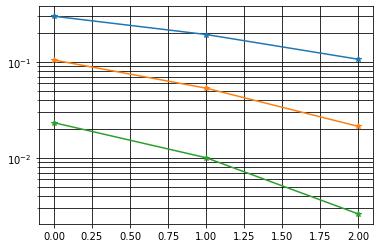

In [7]:
plt.plot(test_nframe/(batch_size*(batches_test/len(ebn0))),marker='*')
plt.plot(BF_test_nframe[:,0]/(batch_size*(batches_test/len(ebn0))),marker='*')
plt.plot(BF_test_nframe[:,1]/(batch_size*(batches_test/len(ebn0))),marker='*')
plt.grid(which='major',color='black',linestyle='-')
plt.grid(which='minor',color='black',linestyle='-')
plt.yscale('log')

In [8]:
file_path = '{0}_{1}_{2}_{3}_{4}_{5}_{6}.ckpt'.format(N,ebn0[0],ebn0[-1],bp_iter_num,RNN,max_flip,load_weight)
f_results = open('Results/Bnd_Pro_'+file_path[:-4]+'txt', 'w+')
f_results.write('Test SNR:    ' + str(ebn0) + '\n')
f_results.write('Test Loss:   ' + str(test_loss/int(batches_test/len(ebn0))) + '\n')
f_results.write('Test BER:    ' + str(test_nfails/(batch_size*K*(batches_test/len(ebn0)))) + '\n')
f_results.write('Test FER:    ' + str(test_nframe/(batch_size*(batches_test/len(ebn0)))) + '\n')
for i in range(max_flip):
    f_results.write('Test BF'+str(i+1)+' FER:' + str(BF_test_nframe[:,i]/(batch_size*(batches_test/len(ebn0)))) + '\n')
f_results.write('NumOfWord:   ' + str(numOfWord) + '\n')
f_results.write('Batch_size:  ' + str(batch_size) + '\n')
f_results.write('Batch_test:  ' + str(batches_test) + '\n')
f_results.flush()